# 02 - Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
logging.getLogger().setLevel(logging.CRITICAL)

In [2]:
# Packages version
print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
print(f'seaborn: {sns.__version__}')
print(f'logging: {logging.__version__}')

pandas: 2.3.1
numpy: 2.2.6
matplotlib: 3.10.3
seaborn: 0.13.2
logging: 0.5.1.2


In [3]:
# Read CSV file
df = pd.read_csv('./Data/Loan Data.csv', sep=';')
df.head()

,YOB,NKID,DEP,PHON,SINC,AES,DAINC,RES,DHVAL,DMORT,DOUTM,DOUTL,DOUTHP,DOUTCC,BAD
0,19.0,4.0,0.0,1,0.0,R,0.0,O,14464.0,4.0,0.0,0.0,0.0,0.0,0.0
1,41.0,2.0,0.0,1,0.0,P,36000.0,O,0.0,0.0,280.0,664.0,0.0,80.0,0.0
2,66.0,0.0,0.0,1,0.0,N,30000.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,51.0,2.0,0.0,1,0.0,P,464.0,O,24928.0,8464.0,584.0,320.0,0.0,60.0,0.0
4,65.0,0.0,0.0,1,0.0,P,15000.0,P,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **🛠️ Data Preparation**

Our data preparation pipeline includes the following steps:

- **Constant Feature Removal**: Eliminating variables with no variance.
- **Correlation Filter**: Removing highly correlated features to reduce multicollinearity.
- **Judgmental Filtering**: Excluding variables based on domain knowledge and expert judgment.
- **Feature Engineering**: Creating and transforming variables to improve model performance.


In [4]:
# Data Split
df_train, df_aux = train_test_split(df, train_size=0.85, stratify=df['BAD'],random_state=42)
df_test, df_val = train_test_split(df_aux, test_size=0.5, stratify=df_aux['BAD'],random_state=42)

# Separate target from features:
X_train = df_train.drop(columns=['BAD'])
y_train = df_train['BAD']

In [5]:
# Constant Feature Removal
def Constant_Filter(df,threshold):
    return [col for col in df.columns if df[col].value_counts(normalize=True).max() >= threshold]

columns_to_drop = Constant_Filter(X_train,0.8)
columns_to_keep = X_train.columns.difference(columns_to_drop).tolist()

X_train_filtered_1 = X_train[columns_to_keep]

print(140*'-')
print('Constant Feature Removal')
print(140*'-')
print(f'Columns to Drop:{columns_to_drop}')
print(f'Columns to Keep:{columns_to_keep}')
print(140*'-')

--------------------------------------------------------------------------------------------------------------------------------------------
Constant Feature Removal
--------------------------------------------------------------------------------------------------------------------------------------------
Columns to Drop:['DEP', 'PHON', 'DOUTHP', 'DOUTCC']
Columns to Keep:['AES', 'DAINC', 'DHVAL', 'DMORT', 'DOUTL', 'DOUTM', 'NKID', 'RES', 'SINC', 'YOB']
--------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------
Correlation Filter
--------------------------------------------------------------------------------------------------------------------------------------------
Columns to Drop:['DHVAL', 'DMORT', 'DOUTM']
Columns to Keep:['YOB', 'NKID', 'DOUTL', 'DAINC', 'SINC', 'RES', 'AES']
--------------------------------------------------------------------------------------------------------------------------------------------


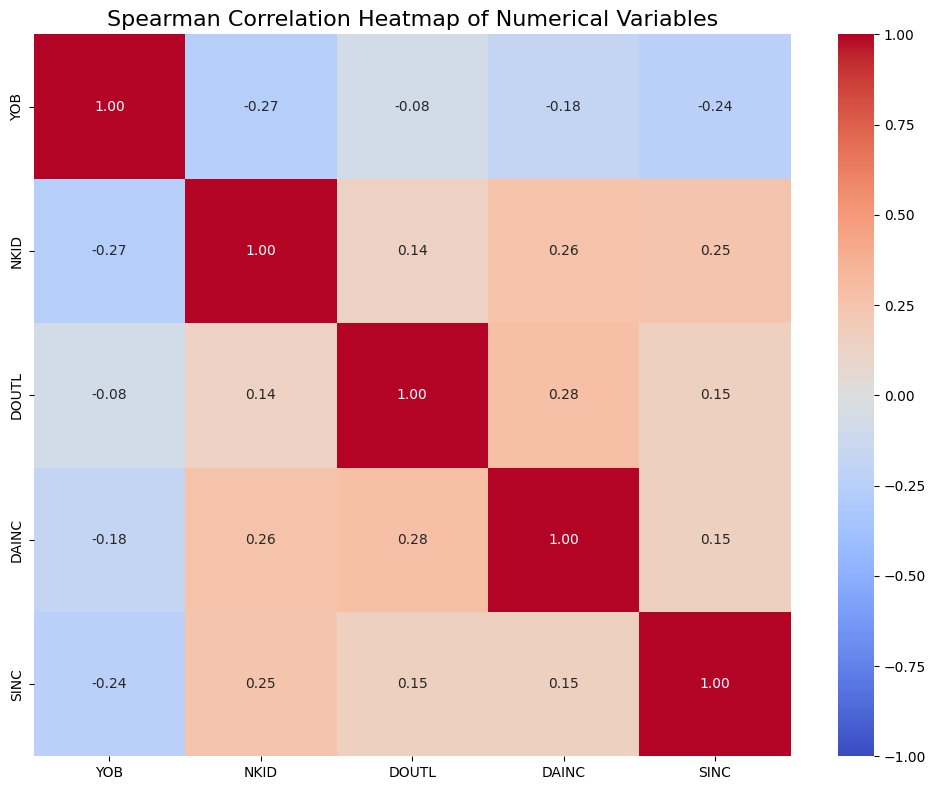

In [6]:
# Correlation Filter
def Correlation_Filter(df, threshold=0.6): 
    
    cols = set(df.columns)
    cor_mat = df.corr()
    
    for col1 in list(cols):
        for col2 in list(cols):
            if col1 != col2 and abs(cor_mat.at[col1, col2]) >= threshold:
                if col2 in cols:
                    cols.remove(col2)
                    
    return list(cols)

columns_to_keep = Correlation_Filter(X_train_filtered_1.drop(columns=['RES','AES']) , 0.4) + ['RES','AES']
columns_to_drop = X_train_filtered_1.columns.difference(columns_to_keep).tolist()

X_train_filtered_2 = X_train_filtered_1[columns_to_keep]

print(140*'-')
print('Correlation Filter')
print(140*'-')
print(f'Columns to Drop:{columns_to_drop}')
print(f'Columns to Keep:{columns_to_keep}')
print(140*'-')

# Compute the correlation matrix
corr_matrix = X_train_filtered_2.drop(columns=['RES','AES']).corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlation Heatmap of Numerical Variables', fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
X_train_filtered_2.describe()

,YOB,NKID,DOUTL,DAINC,SINC
count,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000
mean,50.873199,0.610951,124.318924,21063.792507,1988.863593
std,15.416502,1.011204,904.729899,15733.984142,4871.396099
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,0.000000,0.000000,9276.000000,0.000000
50%,55.000000,0.000000,0.000000,19425.000000,0.000000
75%,63.000000,1.000000,0.000000,30000.000000,1209.000000
max,99.000000,5.000000,28000.000000,64800.000000,50000.000000


OBs. In our Judgmental Filter we chose to discard the non-numeric columns of the remaining dataset.

In [8]:
X_train_filtered_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1041 entries, 350 to 385
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   YOB     1041 non-null   float64
 1   NKID    1041 non-null   float64
 2   DOUTL   1041 non-null   float64
 3   DAINC   1041 non-null   float64
 4   SINC    1041 non-null   float64
 5   RES     1041 non-null   object 
 6   AES     1041 non-null   object 
dtypes: float64(5), object(2)
memory usage: 65.1+ KB


In [9]:
X_train_filtered_2 = X_train_filtered_2.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

df_train_final = X_train_filtered_2.copy()
df_train_final['BAD'] = y_train


df_test_final = df_test[df_train_final.columns]
df_val_final = df_val[df_train_final.columns]

In [14]:
# Feature Engineering
#------------------------------------------------------------------
# 'RES(binary)': Encodes whether the client owns a property.
#                1 if RES == 'O' (owns property)
#                0 otherwise
#------------------------------------------------------------------
# 'AES(binary)': Encodes whether the client has a formal employment.
#                0 if AES in ('W','T','U','N','Z') (formal employment)
#                1 otherwise
#------------------------------------------------------------------
# 'KIDS': Encodes whether the client has kids.
#                0 if NKID == 0 (formal employment)
#                1 otherwise
#------------------------------------------------------------------
# Garantir cópia
df_test_final = df_test_final.copy()
df_val_final = df_val_final.copy()

# Valores não desejados para AES
unwanted = ['W', 'T', 'U', 'N', 'Z']

# TRAIN
df_train_final['RES(binary)'] = (df_train_final['RES'] == 'O').astype(int)
df_train_final['AES(binary)'] = (~df_train_final['AES'].isin(unwanted)).astype(int)
df_train_final['KIDS'] = (df_train_final['NKID'] != 0).astype(int)

# TEST
df_test_final['RES(binary)'] = (df_test_final['RES'] == 'O').astype(int)
df_test_final['AES(binary)'] = (~df_test_final['AES'].isin(unwanted)).astype(int)
df_test_final['KIDS'] = (df_test_final['NKID'] != 0).astype(int)

# VALID
df_val_final['RES(binary)'] = (df_val_final['RES'] == 'O').astype(int)
df_val_final['AES(binary)'] = (~df_val_final['AES'].isin(unwanted)).astype(int)
df_val_final['KIDS'] = (df_val_final['NKID'] != 0).astype(int)


In [15]:
df_train_final.describe()

,YOB,NKID,DOUTL,DAINC,SINC,BAD,RES(binary),AES(binary),KIDS
count,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000
mean,50.873199,0.610951,124.318924,21063.792507,1988.863593,0.263208,0.506244,0.855908,0.324688
std,15.416502,1.011204,904.729899,15733.984142,4871.396099,0.440586,0.500201,0.351352,0.468483
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,0.000000,0.000000,9276.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,55.000000,0.000000,0.000000,19425.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,63.000000,1.000000,0.000000,30000.000000,1209.000000,1.000000,1.000000,1.000000,1.000000
max,99.000000,5.000000,28000.000000,64800.000000,50000.000000,1.000000,1.000000,1.000000,1.000000


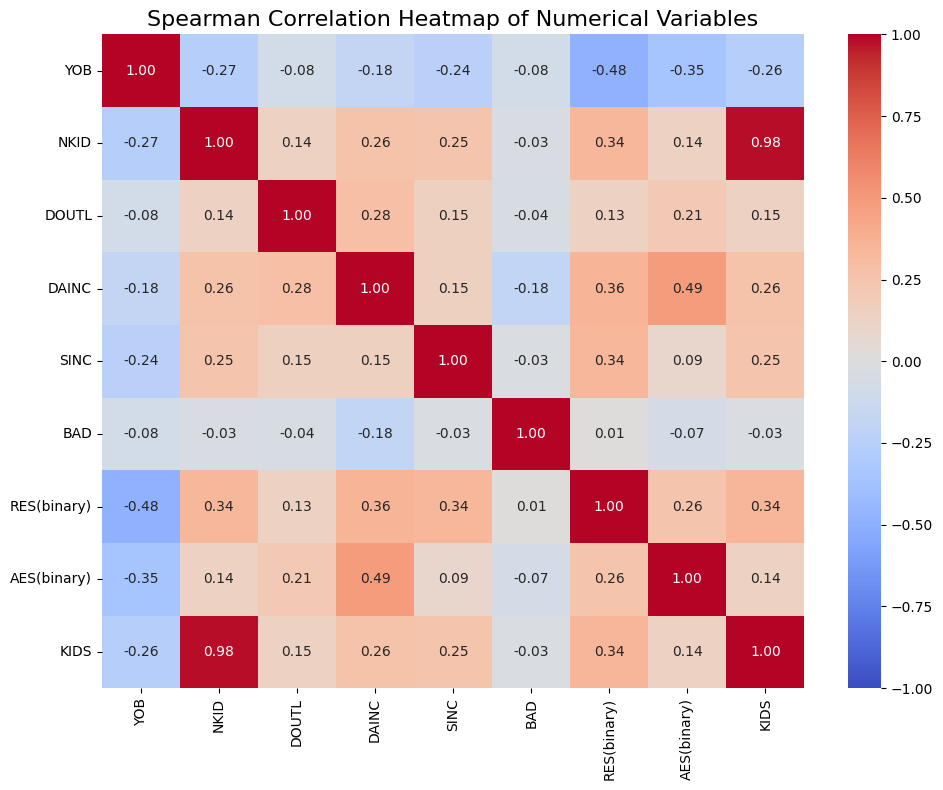

In [16]:
# Compute the correlation matrix
corr_matrix = df_train_final.drop(columns=['AES','RES']).corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlation Heatmap of Numerical Variables', fontsize=16)
plt.tight_layout()
plt.show()

## Final Data Sets

In [17]:
# Exporting the resulting data sets
df_train_final.to_csv('./Data/Train_Data_Set.csv', index=False)
df_test_final.to_csv('./Data/Test_Data_Set.csv', index=False)
df_val_final.to_csv('./Data/Val_Data_Set.csv', index=False)